In [1]:
# get hazard object
import numpy as np
from climada.hazard import Hazard, Centroids
from climada.test import get_test_file

haz_tc_fl = Hazard.from_hdf5(
    get_test_file("HAZ_DEMO_FL_15")
) 
haz_tc_fl.check()

In [32]:
# compute local exceedance instensity
test_return_periods = np.geomspace(1, 15, 20)
local_exceedance_intensity, _, _ = haz_tc_fl.local_exceedance_intensity(
    return_periods=test_return_periods, #method="extrapolate"# method="extrapolate_constant"
)

In [33]:
np.where(local_exceedance_intensity.values[:, 1:].max(axis=1) == np.sort(local_exceedance_intensity.values[:, 1:].max(axis=1))[-1])

(array([1319]),)

In [34]:
from return_period_maps import ReturnPeriodMap, ExceedanceCurve
rp_map = ReturnPeriodMap.from_CLIMADA_local_exceedance_intensity(local_exceedance_intensity)

In [39]:
max_inds = [0, 1227, 1278] #[0,1227, 1278, 1277]
# max_inds = [ 1278] 

from combine_exceedance_curves import combine_exceedance_curves
agg_rp_curve = combine_exceedance_curves(
    [rp_map.exceedance_curves[i] for i in max_inds],
    value_resolution=10.,
    aggregation_method=sum,
    coincidence_fraction=1)

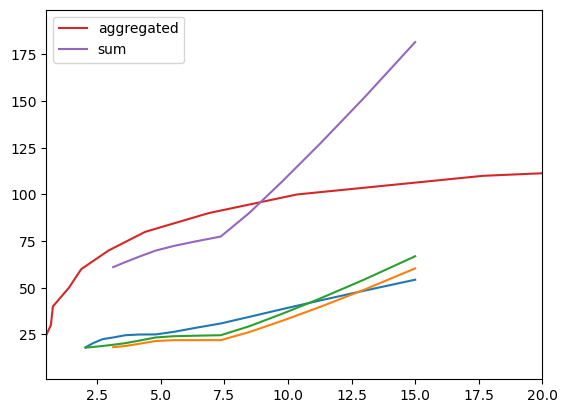

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in max_inds:
    ax.plot(1/rp_map.exceedance_curves[i].exceedance_frequencies, rp_map.exceedance_curves[i].values)

ax.plot(1/agg_rp_curve.exceedance_frequencies, agg_rp_curve.values, label='aggregated')
ax.plot(1/rp_map.exceedance_curves[0].exceedance_frequencies, np.sum([rp_map.exceedance_curves[i].values for i in max_inds], axis=0), label='sum')
ax.legend()
ax.set_xlim(.5, 20);

## Test Carmen RP curves

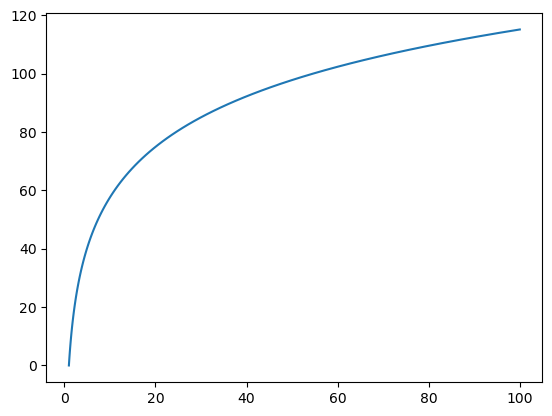

In [16]:
rps_carmen = np.geomspace(1, 100, 100)
exf_carmen = 1/rps_carmen
values_carmen = 25*np.log(rps_carmen)

plt.plot(rps_carmen, values_carmen)

In [17]:
exceedance_curves_carmen = [ExceedanceCurve(
    values=fac*np.log(rps_carmen),
    exceedance_frequencies=exf_carmen,
) for fac in [65, 75]] # left plot
# ) for fac in [25, 70]] # right plot

(1.0, 100.0)

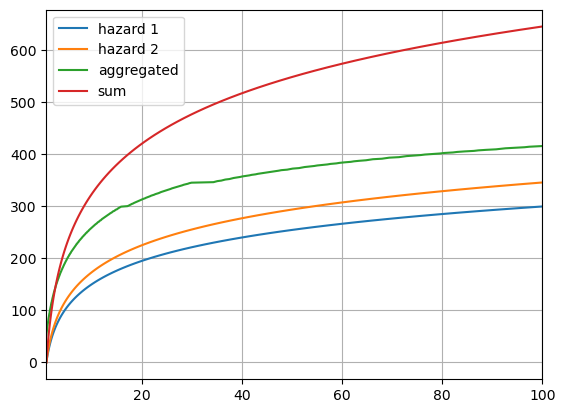

In [18]:
agg_curve_carmen = combine_exceedance_curves(
    exceedance_curves_carmen,
    value_resolution=1.,
    aggregation_method=sum,
    coincidence_fraction=1)

fig, ax = plt.subplots()
for i in [0,1]:
    ax.plot(1/exceedance_curves_carmen[i].exceedance_frequencies, exceedance_curves_carmen[i].values, label=f'hazard {i+1}')


ax.plot(1/agg_curve_carmen.exceedance_frequencies, agg_curve_carmen.values, label='aggregated')
ax.plot(1/exceedance_curves_carmen[0].exceedance_frequencies, np.sum([exceedance_curves_carmen[i].values for i in [0,1]], axis=0), label='sum')
ax.grid()
ax.legend()
ax.set_xlim(1, 100)

In [19]:
(0,1) 

(0, 1)